## Notebook for spike sorting from .kwd data using the Pipeline of mountainsort (linux channel has pipeline)
Uses:
    - intan2kwik (https://github.com/zekearneodo/intan2kwik/blob/master/README.md)
    - mountainlab suite(https://github.com/flatironinstitute/mountainlab-js)
    - mountainsort https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md
    - mountainsort examples https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md

In [1]:
import socket
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from importlib import reload

# pipeline imports
from pipefinch.neural.convert import intan
from pipefinch.neural.sort.mountain import core as msc
from intan2kwik import kwd

#mountainsort imports (for sorting)
#import mountainlab_pytools.mlproc as mlp

import logging

# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)
        
logger.info('Logger set')
logger.info('Hostname {}'.format(socket.gethostname()))

/home/zinch/conda/envs/msort/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zinch/conda/envs/msort/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zinch/conda/envs/msort/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
2019-02-13 12:02:02,968 - root - INFO - Logger set
2019-02-13 12:02:02,968 - root - INFO - Hostname zinch


### Session parameters and raw files

In [130]:
from pipefinch.pipeline import filestructure as et
reload(et)
reload(kwd)

sess_par = {'bird': 'p14r14',
           'sess': '2019-02-13_1750_01'}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'])

logger.info('Raw folder {}'.format(exp_struct['folders']['raw']))
exp_struct

## Convert the whole session to a kwd file
kwik_folder = exp_struct['folders']['kwik']
msort_folder = exp_struct['folders']['msort']
raw_folder = exp_struct['folders']['raw']
kwd_path = exp_struct['files']['kwd']

bin_path = exp_struct['files']['mda_raw']


2019-02-14 12:48:33,478 - root - INFO - Raw folder /mnt/zuperfinchjr/Data/p14r14/ephys/raw/2019-02-13_1750_01


In [3]:
exp_struct

{'folders': {'raw': '/mnt/zuperfinchjr/Data/p14r14/ephys/raw/2019-02-13_1750_01',
  'kwik': '/media/zinch/Windows/experiment/p14r14/ephys/kwik/2019-02-13_1750_01',
  'msort': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01'},
 'files': {'par': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/params.json',
  'set': '/mnt/zuperfinchjr/Data/p14r14/ephys/raw/2019-02-13_1750_01/settings.isf',
  'kwd': '/media/zinch/Windows/experiment/p14r14/ephys/kwik/2019-02-13_1750_01/streams.kwd',
  'kwe': '/media/zinch/Windows/experiment/p14r14/ephys/kwik/2019-02-13_1750_01/events.kwe',
  'mda_raw': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/raw.mda'}}

### convert the whole session to a .kwd file
Conversion sends every .rhd file in the folder to a rec in the .kwd file (experiment.kwd in the session ss folder)
All of the files and all of the channels are converted; filtering and subselection of sub-epochs and channels occurs later.
The .kwd is raw data, only in a friendlier format.


#### Make a file for the session for the first time

In [4]:
reload(kwd)
## Convert the whole session to a kwd file
os.makedirs(kwik_folder, exist_ok=True)
#first_intan_hdr, sess_pd = kwd.intan_to_kwd(raw_folder, kwd_path)

#### Update a session with subsequently recorded rhd files

In [103]:
from pipefinch.h5tools.kwik import kwdfunctions as kwdf
reload(kwdf)
_, nu_pd, _ = kwdf.update_kwd(kwd_path, raw_folder)

2019-02-13 17:03:36,371 - pipefinch.h5tools.kwik.kwdfunctions - INFO - updating kwd file /media/zinch/Windows/experiment/p14r14/ephys/kwik/2019-02-13_1750_01/streams.kwd from folder /mnt/zuperfinchjr/Data/p14r14/ephys/raw/2019-02-13_1750_01
2019-02-13 17:03:36,484 - pipefinch.h5tools.kwik.kwdfunctions - INFO - Will add 28 new files


2019-02-13 17:07:08,106 - pipefinch.h5tools.kwik.kwdfunctions - INFO - merging back to /media/zinch/Windows/experiment/p14r14/ephys/kwik/2019-02-13_1750_01/streams.kwd
2019-02-13 17:07:50,062 - pipefinch.h5tools.kwik.kwdfunctions - INFO - removing temp file


## reading events

In [106]:
import h5py
from pipefinch.h5tools.kwik import kutil
from pipefinch.h5tools.kwik import event as ev
from pipefinch.h5tools.kwik import kwdfunctions as kwdf


In [107]:
reload(ev)
ttl = ev.TTL('ttl', 'DIN', kwd_path)
ttl.event_pd.head()

,rec,edge,ch_idx,t,ch
0,0,1,0,1774099,DIN-00
1,0,0,0,1784100,DIN-00
2,0,1,0,1869221,DIN-00
3,0,0,0,1879222,DIN-00
4,0,1,0,1888822,DIN-00


### align with events

In [108]:
## get all the perceptron trigger events and the mic channel around them

In [109]:
# get all the frames around a trigger for a dataset
reload(kwdf)
ch_name = 'DIN-01'
edge = 1

pd_meta = kwdf.get_all_rec_meta(kwd_path)

# Select channels:
wanted_chans = np.array(['ADC'])
sel_chan_names = kwdf.get_all_chan_names(pd_meta, chan_filt=wanted_chans)
#in this case, that's all the channels



pre_samples = -15000
post_samples = 15000
span = post_samples - pre_samples


ttl = ev.TTL('ttl', 'DIN', kwd_path)
ttl.event_pd.set_index(['ch', 'edge'], inplace=True)

# collect the frames

# go through the recs
ttl_event_pd = ttl.event_pd.loc[ch_name].loc[edge]

reload(kwdf)
all_rec = ttl_event_pd['rec'].values
all_start = ttl_event_pd['t'].values

mic_pst_array = kwdf.get_frames(kwd_path, all_start + pre_samples, all_rec, span, sel_chan_names, pd_meta)


In [170]:
all_rec

array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, 11, 11, 11, 11,
       11, 13, 15, 24, 24, 24, 24, 32, 32, 34, 34, 34, 34, 42])

In [171]:
all_start

array([1946023, 1954023, 1972424, 1976664, 2055545, 2090986, 2214509,
       2234669,  669668,  690389,  711429,  732550,  751030, 1011330,
       2536882, 3861230, 5530385, 5902153,  422225, 1651460, 1209276,
       1229597, 1252797, 1273438,  343652,  363813,  620532,  641172,
        653412,  674453, 2618350])

In [110]:
# get all the lfps around the perceptron trigger:
reload(kwdf)

pre_samples = -15000
post_samples = 15000

neural_port = 'A'
port_chan_names =  kwdf.get_all_chan_names(pd_meta, chan_filt=np.array([neural_port + '-']))

def get_events_lfp(kwd_path, filtered_event_pd, chan_list, pre_samples, post_samples):
    logger.info('Getting chans {}'.format(port_chan_names))
    # get the channels
    meta_pd = kwdf.get_all_rec_meta(kwd_path)
    # set the start, end, span
    all_rec = filtered_event_pd['rec'].values
    all_start = filtered_event_pd['t'].values
    span = post_samples - pre_samples
    # get the data
    frames_array = kwdf.get_frames(kwd_path, all_start + pre_samples, all_rec, span, chan_list, meta_pd)
    return frames_array

lfp_pst_array = get_events_lfp(kwd_path, ttl_event_pd, port_chan_names, pre_samples, post_samples)

2019-02-13 17:08:03,456 - root - INFO - Getting chans ['A-000' 'A-001' 'A-002' 'A-003' 'A-004' 'A-005' 'A-006' 'A-007' 'A-008'
 'A-009' 'A-010' 'A-011' 'A-012' 'A-013' 'A-014' 'A-015' 'A-016' 'A-017'
 'A-018' 'A-019' 'A-020' 'A-021' 'A-022' 'A-023' 'A-024' 'A-025' 'A-026'
 'A-027' 'A-028' 'A-029' 'A-030' 'A-031']


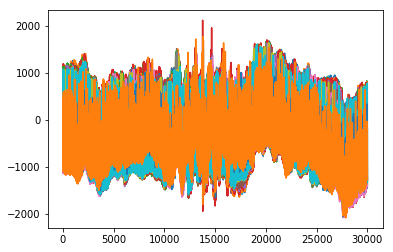

In [111]:
plt.plot(np.mean(lfp_pst_array, axis=0));

In [112]:
ttl_event_pd.head()

,rec,ch_idx,t
edge,,,
1,0,1,1946023
1,0,1,1954023
1,0,1,1972424
1,0,1,1976664
1,0,1,2055545


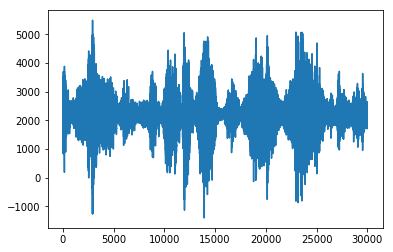

In [169]:
plt.plot(np.nanmean(mic_pst_array, axis=0))

In [166]:
# get all spectrograms
from scipy import signal as sg

def plot_spectrogram(x, before_ms, after_ms, s_f, n_window=512, n_overlap=None, sigma=None, ax=None, **kwargs):
    if n_overlap is None:
        n_overlap = int(n_window*0.75)
    if sigma is None:
        sigma = 1 / 200. * s_f

    # Make the spectrogram
    f, t, Sxx = sg.spectrogram(x, s_f, nperseg=n_window, noverlap=n_overlap, window=sg.gaussian(n_window, sigma),
                            scaling='spectrum')

    Sxx[[Sxx < np.max((Sxx) * 0.000055)]] = 1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms / 1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms / 1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    # Sxx = np.hstack((span_before, (Sxx), span_after))

    #if ax is None:
        #spec_fig, ax = plt.subplots()
        #ax = spec_fig.add_axes([0, 0, 1, 1])

    #ax.pcolormesh(((t - 0.5 * n_window / s_f) * 1000.), f, np.log(Sxx), rasterized=True, cmap='inferno')
    #ax.set_xlim(-before_ms, after_ms + int(x.size / s_f * 1000.))
    #ax.set_ylim(0, 10000)
    #ax.imshow(np.log(Sxx[::-1]), aspect='auto', cmap='inferno', rasterized=True)
    # ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    return Sxx

sxx = plot_spectrogram(mic_pst_array[:, :, 0], 0, 0, 20000);
sxx.shape

/home/zinch/conda/envs/msort/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


(31, 257, 231)

/home/zinch/conda/envs/msort/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


(7967, 231)

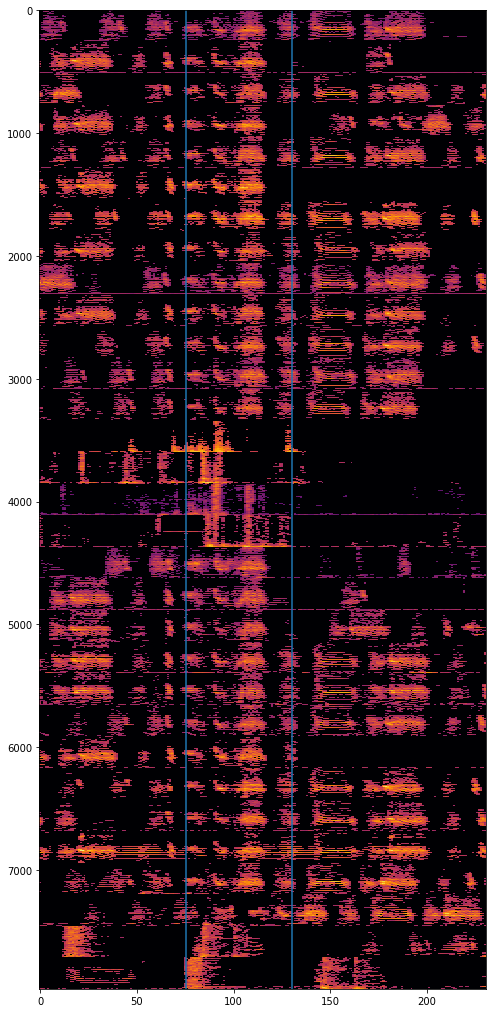

In [167]:
many_spec = [plot_spectrogram(mic_pst_array[i, :, 0], 0, 0, 20000) for i in np.arange(mic_pst_array.shape[0])];
spec_arr = np.vstack(many_spec)
fig, ax = plt.subplots(figsize=(8, 18))
mark = pre_samples/span * spec_arr.shape[1] * (-1)

ax.imshow(np.log(spec_arr[::-1]), aspect='auto', cmap='inferno')

ax.axvline(x=mark+15)
ax.axvline(x=mark-40)
spec_arr.shape

In [168]:
spec_arr.shape

(7967, 231)

In [117]:
bad_ones = np.array([5, 6, 40, 36, 35, 34, 33, 32, 27, 24, 41, 43, 60, 55, 65, 68])
out_spec = [plot_spectrogram(all_frames_array[i, :, 0], 0, 0, 20000) for i in bad_ones];
out_spec_arr = np.vstack(out_spec)
fig, ax = plt.subplots(figsize=(8, 18))
mark = pre_samples/span * spec_arr.shape[1] * (-1)

ax.imshow(np.log(out_spec_arr[::-1]), aspect='auto', cmap='inferno')

ax.axvline(x=mark)
spec_arr.shape

NameError: name 'all_frames_array' is not defined

### a quick look at the right/wrong triggers

In [24]:
import umap
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape

(1797, 64)

In [72]:
all_spec_flat = np.vstack([x[:, 115-50:115+25].flatten() for x in many_spec])
all_spec_flat.shape
embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.3,
                      metric='manhattan').fit_transform(all_spec_flat)
plt.scatter(
    embedding[:, 0], embedding[:, 1])
plt.scatter(embedding[bad_ones,0], embedding[bad_ones,1])

NameError: name 'umap' is not defined

In [71]:
all_spec_flat.shape

NameError: name 'all_spec_flat' is not defined

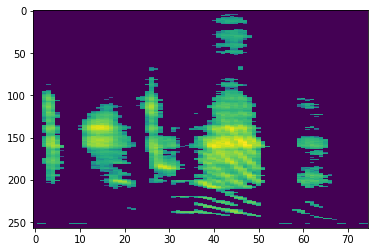

In [56]:
avg_spec = np.median(all_spec_flat, axis=0)
plt.imshow(np.log(avg_spec.reshape(257, -1)[::-1]), aspect='auto')

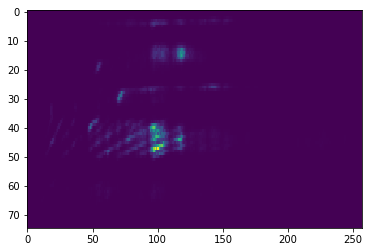

In [57]:
plt.imshow(avg_spec.reshape(257, -1).T, aspect='auto')

In [58]:
outliers = np.where(embedding[:, 1]<0)[0]
outliers.shape

(0,)

### Kwd file to mda 

## Select a subset of a kwd file:
 - a set of recordings (e.g, by range of time)
 - a set of channels (by identifier) (e.g: a whole port from the intan, like 'A-', or the channel where the mic is, like 'ADC-00')

In [118]:
np.unique(np.hstack(pd_meta.loc[:, 'channel_names'].values))

array(['A-000', 'A-001', 'A-002', 'A-003', 'A-004', 'A-005', 'A-006',
       'A-007', 'A-008', 'A-009', 'A-010', 'A-011', 'A-012', 'A-013',
       'A-014', 'A-015', 'A-016', 'A-017', 'A-018', 'A-019', 'A-020',
       'A-021', 'A-022', 'A-023', 'A-024', 'A-025', 'A-026', 'A-027',
       'A-028', 'A-029', 'A-030', 'A-031', 'ADC-00'], dtype='<U6')

In [119]:
reload(kwdf)
pd_meta = kwdf.get_all_rec_meta(kwd_path)

# Select channels:
wanted_chans = np.array(['A-', 'ADC'])

all_chan_names = kwdf.get_all_chan_names(pd_meta)

sel_chan_names = kwdf.get_all_chan_names(pd_meta, chan_filt=wanted_chans)

#in this case, that's all the channels
sel_chan_names

array(['A-000', 'A-001', 'A-002', 'A-003', 'A-004', 'A-005', 'A-006',
       'A-007', 'A-008', 'A-009', 'A-010', 'A-011', 'A-012', 'A-013',
       'A-014', 'A-015', 'A-016', 'A-017', 'A-018', 'A-019', 'A-020',
       'A-021', 'A-022', 'A-023', 'A-024', 'A-025', 'A-026', 'A-027',
       'A-028', 'A-029', 'A-030', 'A-031', 'ADC-00'], dtype='<U6')

In [120]:
wanted_chans = np.array(['A-']) # all ephys channels
chan_list = kwdf.get_all_chan_names(pd_meta, chan_filt=wanted_chans)

## Make .mda file with a set of recordings in a session
 - pick all in port A
 - get all rec within a time range


In [121]:
exp_struct['folders']

{'raw': '/mnt/zuperfinchjr/Data/p14r14/ephys/raw/2019-02-13_1750_01',
 'kwik': '/media/zinch/Windows/experiment/p14r14/ephys/kwik/2019-02-13_1750_01',
 'msort': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01'}

In [172]:
all_rec_list

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

In [122]:
reload(kwdf)
reload(kutil)
ch.setLevel(logging.INFO)

all_rec_list = kutil.get_rec_list(kwd_path)
all_rec_list

wanted_chans = np.array(['A-']) # all ephys channels
chan_list = kwdf.get_all_chan_names(pd_meta, chan_filt=wanted_chans)

bin_path = exp_struct['files']['mda_raw']
os.makedirs(exp_struct['folders']['msort'], exist_ok=True)
bin_file = kwdf.kwd_to_binary(exp_struct['files']['kwd'], exp_struct['files']['mda_raw'], chan_list=chan_list, rec_list=all_rec_list, header='mda')
rec_attr_dict = kwdf.get_rec_attrs(exp_struct['files']['kwd'], 0)
all_rec_meta_pd = kwdf.get_all_rec_meta(exp_struct['files']['kwd'])

2019-02-13 17:08:43,400 - pipefinch.h5tools.kwik.kwdfunctions - INFO - Writing kwd_file /media/zinch/Windows/experiment/p14r14/ephys/kwik/2019-02-13_1750_01/streams.kwd to binary
2019-02-13 17:08:43,448 - pipefinch.h5tools.kwik.kwdfunctions - INFO - Channels to extract: ['A-000' 'A-001' 'A-002' 'A-003' 'A-004' 'A-005' 'A-006' 'A-007' 'A-008'
 'A-009' 'A-010' 'A-011' 'A-012' 'A-013' 'A-014' 'A-015' 'A-016' 'A-017'
 'A-018' 'A-019' 'A-020' 'A-021' 'A-022' 'A-023' 'A-024' 'A-025' 'A-026'
 'A-027' 'A-028' 'A-029' 'A-030' 'A-031']
2019-02-13 17:08:43,449 - pipefinch.h5tools.kwik.kwdfunctions - INFO - Will go through recs [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
2019-02-13 17:08:43,450 - pipefinch.h5tools.kwik.kwdfunctions - INFO - Creating binary file /media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/raw.mda


2019-02-13 17:08:43,559 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/0
2019-02-13 17:08:51,973 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/1
2019-02-13 17:08:55,917 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/2
2019-02-13 17:08:56,708 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/3
2019-02-13 17:08:58,040 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/4
2019-02-13 17:08:59,821 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/5
2019-02-13 17:09:01,803 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/6
2019-02-13 17:09:03,505 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/7
2019-02-13 17:09:04,725 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/8
2019-02-13 17:09:05,972 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/9


In [85]:
rec_chans = pd_meta.loc[pd_meta['name']==0, 'channel_names'].values
kwdf.find_chan_names_idx(rec_chans[0], chan_list)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

#### test that the mda was written ok by looking at the microphone channel

In [86]:
from mountainlab_pytools import mdaio
loaded_mda = mdaio.readmda(bin_path)

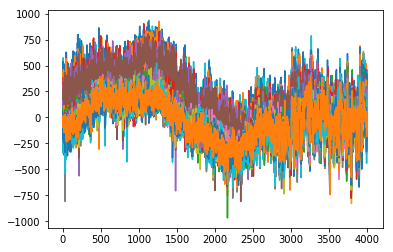

In [87]:
start = 8400000 + 30000
end = start + 4000
plt.plot(loaded_mda[:, start:end].T);

### tyr to fix the channel namimg

In [88]:
all_rec_meta_pd.head()

,bit_depth,sample_rate,name,start_sample,start_time,is_multiSampleRate_data,channels_sample_rate,channel_bit_volts,channel_names,dig_channel_names,valid_samples,samples_count
0,16,20000.0,0,0,2019-02-13 10:12:10,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[A-000, A-001, A-002, A-003, A-004, A-005, A-0...","[DIN-00, DIN-01]","[11903040.0, 11903040.0, 11903040.0, 11903040....",11903040
1,16,20000.0,1,0,2019-02-13 10:28:16,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[A-000, A-001, A-002, A-003, A-004, A-005, A-0...","[DIN-00, DIN-01]","[5999760.0, 5999760.0, 5999760.0, 5999760.0, 5...",5999760
2,16,20000.0,2,0,2019-02-13 10:33:10,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[A-000, A-001, A-002, A-003, A-004, A-005, A-0...","[DIN-00, DIN-01]","[1211760.0, 1211760.0, 1211760.0, 1211760.0, 1...",1211760
3,16,20000.0,3,0,2019-02-13 10:34:53,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[A-000, A-001, A-002, A-003, A-004, A-005, A-0...","[DIN-00, DIN-01]","[1964880.0, 1964880.0, 1964880.0, 1964880.0, 1...",1964880
4,16,20000.0,4,0,2019-02-13 10:36:34,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[A-000, A-001, A-002, A-003, A-004, A-005, A-0...","[DIN-00, DIN-01]","[2707200.0, 2707200.0, 2707200.0, 2707200.0, 2...",2707200


In [151]:
all_rec_meta_pd.loc[0, 'channel_names']

array(['A-000', 'A-001', 'A-002', 'A-003', 'A-004', 'A-005', 'A-006',
       'A-007', 'A-008', 'A-009', 'A-010', 'A-011', 'A-012', 'A-013',
       'A-014', 'A-015', 'A-016', 'A-017', 'A-018', 'A-019', 'A-020',
       'A-021', 'A-022', 'A-023', 'A-024', 'A-025', 'A-026', 'A-027',
       'A-028', 'A-029', 'A-030', 'A-031', 'ADC-00'], dtype='<U6')

In [150]:
pd_slice = apd['name'].isin(np.array([0, 5, 7]))
apd.loc[pd_slice]

NameError: name 'apd' is not defined

## Scripts for sorting

### prep the files with their nice formats, locations and names


In [152]:
reload(msc)
file_paths, out_folder = msc.make_paths(exp_struct['folders']['msort'])
os.makedirs(exp_struct['folders']['msort'], exist_ok=True)
#todo:
# meta and pars from intan files et al
s_f = 20000

# parameters to pass to the msort scripts
ds_params = {'samplerate': int(kwdf.get_sampling_rate(all_rec_meta_pd, 0)),
            'detect_sign': -1}

with open(file_paths['params'], 'w') as fp:
    json.dump(ds_params, fp)
    logger.info('Created session par files {}'.format(file_paths['params']))


2019-02-14 15:32:37,809 - root - INFO - Created session par files /media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/params.json


In [153]:
ds_params

{'samplerate': 20000, 'detect_sign': -1}

In [154]:
file_paths

{'mda': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/raw.mda',
 'params': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/params.json',
 'geom': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/geom.csv',
 'filt': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/filt.mda.prv',
 'pre': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/pre.mda.prv',
 'firings': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/firings.mda',
 'firings_curated': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/firings_curated.mda',
 'cluster_metrics': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/cluster_metrics.json',
 'cluster_metrics_curated': '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/cluster_metrics_curated.json'}

In [155]:
# test mountainsort method for reading sorting parameters
msc.read_dataset_params(exp_struct['folders']['msort'])

{'samplerate': 20000, 'detect_sign': -1}

In [98]:
# Initialize a pipeline
from mountainlab_pytools import mlproc as mlp
Pipeline=mlp.initPipeline();

JSProxyWidget(status='Not yet rendered')

In [99]:
msc.sort_dataset?

Signature: msc.sort_dataset(*, file_paths:dict, freq_min:int=300, freq_max:int=6000, adjacency_radius:int=1, detect_threshold:float=3, dispatch_method:str='run', opts:dict={})
Docstring: <no docstring>
File:      ~/repos/pipefinch/pipefinch/neural/sort/mountain/core.py
Type:      function


In [101]:
output_dir = os.path.join(exp_struct['folders']['msort'], 'sort_out');
# Pipeline was failing, need to debug this ('NameError: name 'widgets' is not defined')
# with Pipeline:
#     msc.sort_dataset(file_paths=file_paths, adjacency_radius=-1, detect_threshold=3, dispatch_method='add')

msc.sort_dataset(file_paths=file_paths, adjacency_radius=-1, detect_threshold=2, freq_min=600);

2019-02-13 15:42:13,186 - pipefinch.sort.mountain.comre - INFO - Bandpass filter


RUNNING: ml-run-process ephys.bandpass_filter --inputs timeseries:/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/raw.mda --parameters freq_max:6000 freq_min:600 samplerate:20000 --outputs timeseries_out:/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/filt.mda.prv
[ Getting processor spec... ]
This is only a warning: Unable to hard link file /media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/raw.mda -> /tmp/mountainlab-tmp/tempdir_e0e7db1fd9_hPq9fv/input_timeseries_SR40IBim.mda. Perhaps temporary directory is not on the same device as the output file directory. Copying instead.


2019-02-13 15:43:21,875 - pipefinch.sort.mountain.comre - INFO - Whitening


[ Checking inputs and substituting prvs ... ]
[ Computing process signature ... ]
Process signature: e0e7db1fd9ba602fbcf371343647a3f4a6dd1d78
[ Checking outputs... ]
{"timeseries_out":"/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/filt.mda.prv"}
Processing ouput - /media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/filt.mda.prv
false
{"timeseries_out":"/tmp/mountainlab-tmp/output_e0e7db1fd9ba602fbcf371343647a3f4a6dd1d78_timeseries_out.mda"}
[ Checking process cache ... ]
[ Creating temporary directory ... ]
[ Creating links to input files... ]
[ Preparing temporary outputs... ]
Processing ouput - /tmp/mountainlab-tmp/output_e0e7db1fd9ba602fbcf371343647a3f4a6dd1d78_timeseries_out.mda
false
[ Initializing process ... ]
[ Running ... ] /home/zinch/conda/envs/msort/bin/python3 /home/zinch/conda/envs/msort/etc/mountainlab/packages/ml_ephys/preprocessing/preprocessing.py.mp ephys.bandpass_filter --_tempdir=/tmp/mountainlab-tmp/tempd

2019-02-13 15:44:09,186 - pipefinch.sort.mountain.comre - INFO - Sorting


[ Getting processor spec... ]
[ Checking inputs and substituting prvs ... ]
[ Computing process signature ... ]
Process signature: c472b4247c9f9deac882511b35af17864b8a46eb
[ Checking outputs... ]
{"timeseries_out":"/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/pre.mda.prv"}
Processing ouput - /media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/pre.mda.prv
false
{"timeseries_out":"/tmp/mountainlab-tmp/output_c472b4247c9f9deac882511b35af17864b8a46eb_timeseries_out.mda"}
[ Checking process cache ... ]
[ Creating temporary directory ... ]
[ Creating links to input files... ]
[ Preparing temporary outputs... ]
Processing ouput - /tmp/mountainlab-tmp/output_c472b4247c9f9deac882511b35af17864b8a46eb_timeseries_out.mda
false
[ Initializing process ... ]
[ Running ... ] /home/zinch/conda/envs/msort/bin/python3 /home/zinch/conda/envs/msort/etc/mountainlab/packages/ml_ephys/preprocessing/preprocessing.py.mp ephys.whiten --_tempdir=/tmp/mo

/home/zinch/repos/pipefinch/pipefinch/neural/sort/mountain/core.py:168: UserWarning: Will sort with no geometry input
  warnings.warn('Will sort with no geometry input')


RUNNING: ml-run-process ms4alg.sort --inputs timeseries:/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/pre.mda.prv --parameters adjacency_radius:-1 detect_sign:-1 detect_threshold:2 --outputs firings_out:/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/firings.mda
[ Getting processor spec... ]
/home/zinch/conda/envs/msort/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
[ Checking inputs and substituting prvs ... ]
return f(*args, **kwds)
[ Computing process signature ... ]

Process signature: c29e755a4378a6e6bf5405495a6f3794478460fb
This is only a warning: Unable to rename file /tmp/mountainlab-tmp/tempdir_c29e755a43_tjNxGf/output_firings_out.mda -> /media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/firings.mda. Perhaps temporary directory is not on the same device as the outpu

2019-02-13 15:57:22,529 - pipefinch.sort.mountain.comre - INFO - Getting cluster metrics


[ Checking outputs... ]
{"firings_out":"/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/firings.mda"}
Processing ouput - /media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/firings.mda
false
{"firings_out":"/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/firings.mda"}
[ Checking process cache ... ]
[ Creating temporary directory ... ]
[ Creating links to input files... ]
[ Preparing temporary outputs... ]
Processing ouput - /media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/firings.mda
false
[ Initializing process ... ]
[ Running ... ] /home/zinch/conda/envs/msort/bin/python3 /home/zinch/conda/envs/msort/etc/mountainlab/packages/ml_ms4alg/ms4alg_spec.py.mp ms4alg.sort --_tempdir=/tmp/mountainlab-tmp/tempdir_c29e755a43_tjNxGf --timeseries=/tmp/mountainlab-tmp/tempdir_c29e755a43_tjNxGf/input_timeseries_NgjUT1o4.mda --geom= --firings_out=/tmp/mountainlab-tmp/tempdir_c29e755

2019-02-13 15:58:34,515 - pipefinch.sort.mountain.comre - INFO - Automatically curating


[ Getting processor spec... ]
This is only a warning: Unable to rename file /tmp/mountainlab-tmp/tempdir_557214ad72_XUd5Wb/output_metrics_out.json -> /media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/cluster_metrics.json. Perhaps temporary directory is not on the same device as the output file directory. Copying instead.
[ Checking inputs and substituting prvs ... ]
[ Computing process signature ... ]
Process signature: 557214ad72157bd9030d51f7610f7b2c83afe5f5
[ Checking outputs... ]
{"metrics_out":"/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/cluster_metrics.json"}
Processing ouput - /media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/cluster_metrics.json
false
{"metrics_out":"/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/cluster_metrics.json"}
[ Checking process cache ... ]
[ Creating temporary directory ... ]
[ Creating links to input files... ]
[ Preparing temp

In [ ]:
file_paths

## Command for viewing:
 - open up terminal with the environment msort
 - go go the ss_data folder for the session
 - run the command: qt-mountainview --raw raw.mda --filt sort_out/filt.mda.prv --pre sort_out/pre.mda.prv --samplerate=20000 --firings sort_out/firings.mda --cluster_metrics sort_out/cluster_metrics.json

# After manual curation
 - save the curated spikes in the sort_out/firings_curated.mda
 - come back to the notebook and run 

In [173]:
from pipefinch.h5tools.kwik import kwikfunctions as kwkf
reload(kwkf)
reload(et)
firings_to_save = 'firings' # 'curated' or 'firings' for default_output


metrics_to_save = 'cluster_metrics_curated' if firings_to_save == 'firings_curated' else 'cluster_metrics'
kwkf.mda_to_kwik(exp_struct['files']['kwd'],
                 exp_struct['files']['kwik'],
                 file_paths[firings_to_save],
                file_paths[metrics_to_save])


2019-02-15 11:34:09,949 - pipefinch.h5tools.kwik.kwikfunctions - INFO - Creating kwik file /media/zinch/Windows/experiment/p14r14/ephys/kwik/2019-02-13_1750_01/spikes.kwik from firings /media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/firings.mda


FileNotFoundError: [Errno 2] No such file or directory: '/media/zinch/Windows/experiment/p14r14/ephys/msort/2019-02-13_1750_01/sort_out/firings.mda'

In [5]:
import json

In [2]:
rig_par = {'chan': {'ttl': {'trig_perceptron': 'DIN-01', 'trig_recording': 'DIN-00'}, 
                   'adc': {'microphone_0': 'ADC-00'},
                   'port': {'probe_0': 'A-'}
                 },
           'probe': {'probe_0': {'model': 'a1x32-edge-5mm-20-177_H32',
                                'serial': '768b',
                                'headstage': 'intan32-h32'}}
          }

In [7]:
!pwd

/home/zinch/repos/pipefinch


In [14]:
with open('rig.json', 'w') as fp:
    json.dump(rig_par, fp)

In [16]:
with open('rig.json', 'r') as fp:
    rpar = json.load(fp)